<h1><center> Regresion over Energie barries and Loop lifetime</center><h1></h1>
<h2>Imports and helper functions</h2>

In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

<h3>Constants</h3>

In [2]:
#Contans
pi = np.pi
kb = 8.617333262145e-5  # Boltzmann constant in eV/K
T = 800 + 273.15        # Temperature in Kelvin

<h3>Helper functions</h3>

In [3]:
# Helper functions
def D_Coeff(D_0, E_m, T):
    return D_0 * np.exp(-E_m / (kb * T))

def log_factor(r_0, r_L):
    logt = np.log(8 * r_L / r_0)
    r = r_0 * logt
    return 1 / r 

def compute_j_L_i(C_Th_i, D_Th_i, r_0, r_L):
    log_fact = log_factor(r_0, r_L)
    num = D_Th_i * C_Th_i
    return log_fact * num 

def compute_j_ii(C_Th_i, C_O_i, D_Th_i, D_O_i, eta, Z_2_Th = 6, Z_2_O = 6):
    
    numerator = Z_2_Th * D_Th_i * (C_Th_i**2) * Z_2_O * D_O_i * (C_O_i**2)
    denominator = 2 * Z_2_Th * D_Th_i * (C_Th_i**2) + Z_2_O * D_O_i * (C_O_i**2)
    
    return eta * numerator / denominator 

def loop_life_time_term(N_L, R_L, alpha, beta, k_lf):
    pro = np.power(N_L, alpha) * np.power(R_L, beta)
    return k_lf * np.power(N_L, alpha) * np.power(R_L, beta)


<h3>Data reader</h3>

In [4]:
#Data reader
def load_data(file, colnames, path = '../../data/'):
    filename = path + file
    df = pd.read_csv(filename, names = colnames, dtype=float, skiprows=1)
    return df

<h2>ODE System</h2>

In [5]:
# ODE system
def ODE_system(t, y, params):
    C_Th_v, C_O_v, C_Th_i, C_O_i, N_L, R_L = y

    G_Th_v = params['G_Th_v']
    G_O_v  = params['G_O_v']
    G_Th_i = params['G_Th_i']
    G_O_i  = params['G_O_i']
    a     = params['a']
    Omega_0 = (a**3) / 12
    D_Th_i = params['D_Th_i']
    D_O_i  = params['D_O_i']
    D_Th_v = params['D_Th_v']
    D_O_v  = params['D_O_v']
    r0     = params['r0']
    L = params['L']
    b = a / np.sqrt(3)
    alpha = params['alpha']
    beta = params['beta']
    k_lf = params['k_lf']
    eta =  Omega_0 / a**2
    st   = 2 * pi * R_L * N_L

     
    j_L_i = 0
    j_ii = 0
    
    if C_Th_i != 0 or C_O_i != 0:
        j_L_i = compute_j_L_i(C_Th_i, D_Th_i, r0, R_L)
        j_ii  = compute_j_ii(C_Th_i, C_O_i, D_Th_i, D_O_i, eta)
    
    tau = loop_life_time_term(N_L, R_L, alpha, beta, k_lf)
    
    k_Th = eta * (48 * D_Th_i + 48 * D_Th_i)
    k_O  = eta * (36 * D_O_i + 24 * D_O_i)

    c_lamalle = 12/(L**2)

    
    dc = np.zeros(6)
    
    #R_L evolution
    
    dc[5] = 3 * Omega_0 * 2 * pi * r0 * j_L_i / b

    dc[4] =  j_ii 

    if tau != 0 :
        dc[4] -=  N_L / tau
    

    
    if dc[5] < 0 and R_L <= 2*r0:
        dc[5] = 0

    if dc[4] < 0 and N_L <= 0:
        dc[4] = 0

    dc[0] = G_Th_v - k_Th * C_Th_v * C_Th_i # - c_lamalle * D_Th_v * C_Th_v (neglected)
    dc[1] = G_O_v  - k_O  * C_O_v  * C_O_i  - c_lamalle * D_O_v * C_O_v
    dc[2] = G_Th_i - k_Th * C_Th_i * C_Th_v - c_lamalle * D_Th_i * C_Th_i  - j_L_i * pi * r0 * st - j_ii
    dc[3] = G_O_i  - k_O  * C_O_i  * C_O_v  - c_lamalle * D_O_i * C_O_i - 2 * j_L_i * pi * r0 * st - 2 * j_ii

    return dc


<h2>Fit function</h2>

In [6]:
def fit_function(E_Th_i, E_O_v, E_O_i, k_lf,
                 dose_exp_R, dose_exp_N, y0, t_span, ode_params, G_0, t_eval):

    E_Th_v = 5.0  # fixed

    ode_params['D_Th_i'] = D_Coeff(D_0_Th_i, E_Th_i, T)
    ode_params['D_Th_v'] = D_Coeff(D_0_Th_v, E_Th_v, T)
    ode_params['D_O_i']  = D_Coeff(D_0_O_i,  E_O_i, T)
    ode_params['D_O_v']  = D_Coeff(D_0_O_v,  E_O_v, T)
    ode_params['k_lf']   = k_lf

    # Solve ODE
    sol = solve_ivp(
        ODE_system, t_span, y0, args=(ode_params,),
        method="BDF", t_eval=t_eval, rtol=1e-6, atol=1e-9
    )

    # Check solver success
    if not sol.success:
        print("Solver failed:", sol.message)
        # Return NaNs so curve_fit knows this set of parameters is bad
        return np.full(len(dose_exp_R) + len(dose_exp_N), np.nan)

    dose_model = sol.t * G_0

    R_model = np.interp(dose_exp_R, dose_model, sol.y[5, :])  # radius
    N_model = np.interp(dose_exp_N, dose_model, sol.y[4, :])  # density

    return np.concatenate([R_model, N_model])

<h2>Ploting function</h2>

In [7]:
def interactive_plots(results, G_0):
    time = results['time']
    dose = time * G_0

    # Ce Concentrations
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=time, y=results['C_Th_v'],
                              mode='lines', name='C_Th_v'))
    fig1.add_trace(go.Scatter(x=time, y=results['C_Th_i'],
                              mode='lines', name='C_Th_i'))
    fig1.update_layout(title="Vacancy Concentrations",
                       xaxis=dict(title="Time [s]", type="log",  exponentformat='power'),
                       yaxis=dict(title="Concentration [cm<sup>-3</sup>]", type="log", exponentformat='power'),
                       width=600, height=500)
    fig1.show()

    # O Concentrations
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=time, y=results['C_O_v'],
                              mode='lines', name='C_O_v'))
    fig2.add_trace(go.Scatter(x=time, y=results['C_O_i'],
                              mode='lines', name='C_O_i'))
    fig2.update_layout(title="Interstitial Concentrations",
                       xaxis=dict(title="Time [s]", type="log", exponentformat='power'),
                       yaxis=dict(title="Concentration [cm<sup>-3</sup>]", type="log", exponentformat='power'),
                       width=600, height=500)
    fig2.show()

    # Loop density
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=dose, y=results['N_L']*1e-16,
                              mode='lines', name='N_L'))
    fig3.update_layout(title="Dislocation Loop Density",
                       xaxis=dict(title="Dose [dpa]"),
                       yaxis=dict(title="Loop Density [ 10<sup>16</sup> cm<sup>-3</sup>] "),
                       width=600, height=500)
    fig3.show()

    # Loop radius
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=dose, y=results['R_L']*1e7,
                              mode='lines', name='R_L'))
    fig4.update_layout(title="Dislocation Loop Radius",
                       xaxis=dict(title="Dose [dpa]"),
                       yaxis=dict(title="Loop Radius [nm]"),
                       width=600, height=500)
    fig4.show()


<h2>Doing the fit</h2>
<h3>Defining parameters</h3>

In [8]:
#Parameters
a = 561e-10   # cm
N = 12 
Omega_0 = (a**3) / N
b = a / np.sqrt(3)

L = 100e-7 # Lamallae thickness cm

#Scenario B
alpha = 1
beta = 1

D_0_Th_v, D_0_Th_i, D_0_O_v, D_0_O_i = 0.65, 0.01, 0.02, 0.01

E_m_Th_v, E_m_Th_i, E_m_O_v, E_m_O_i = 5.0, 3.15, 2.08, 0.9

# Dose rate dpa/s
G_Th_0 = 0.39e-3  
G_O_0 = 1.54e-3

# Dose rato to dpa/(s*cm^-3)

G_Th = G_Th_0 / Omega_0 
G_O  = G_O_0 / Omega_0
r0 = 180.4e-10 #cm

k_lf = 6.28

ode_params = {
    'G_Th_v': G_Th, 'G_O_v': G_O,
    'G_Th_i': G_Th, 'G_O_i': G_O,
    'a': a, 
    'D_Th_i': D_Coeff(D_0_Th_i, E_m_Th_i, T),
    'D_Th_v': D_Coeff(D_0_Th_v, E_m_Th_v, T),
    'D_O_i':  D_Coeff(D_0_O_i,  E_m_O_i, T),
    'D_O_v':  D_Coeff(D_0_O_v,  E_m_O_v, T),
    'r0': r0,
    'L': L,
    'alpha': alpha,
    'beta': beta,
    'k_lf': k_lf
}

print(f"D_Ce_i = {ode_params['D_Th_i']:.3e} cm^2/s")
print(f"D_Ce_v = {ode_params['D_Th_v']:.3e} cm^2/s")
print(f"D_O_i  = {ode_params['D_O_i']:.3e} cm^2/s")
print(f"D_O_v  = {ode_params['D_O_v']:.3e} cm^2/s")
print(f"G_Ce   = {ode_params['G_Th_v']:.3e} dpa/(s*cm^3)")
print(f"G_O   = {ode_params['G_O_v']:.3e} dpa/(s*cm^3)")


D_Ce_i = 1.610e-17 cm^2/s
D_Ce_v = 2.146e-24 cm^2/s
D_O_i  = 5.934e-07 cm^2/s
D_O_v  = 3.411e-12 cm^2/s
G_Ce   = 2.651e+19 dpa/(s*cm^3)
G_O   = 1.047e+20 dpa/(s*cm^3)


In [9]:
# Initial conditions
t0 = 0.0001149
y0 = [G_Th*t0, G_O*t0, G_Th*t0, G_O*t0, G_O*t0*1e-6, np.sqrt(N*Omega_0/(pi*b))]

#Damage rate dpa/s
G_0 = 1.9e-3

# Total time from total dose
dmg = 3.0   # dpa
t_end = dmg / G_0
t_span = (t0, t_end)
t_eval = np.linspace(t0, t_end, 3000)


<h3>Testing ODE system</h3>

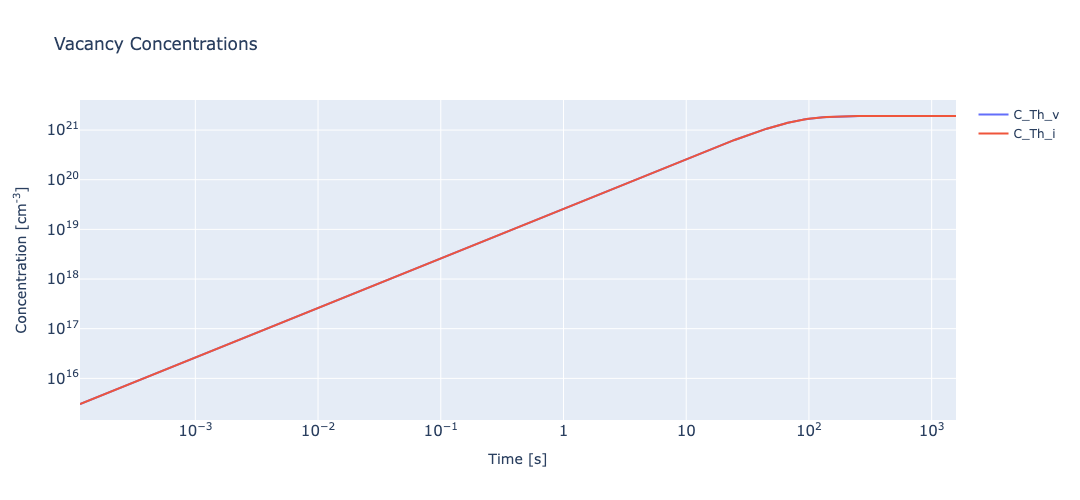

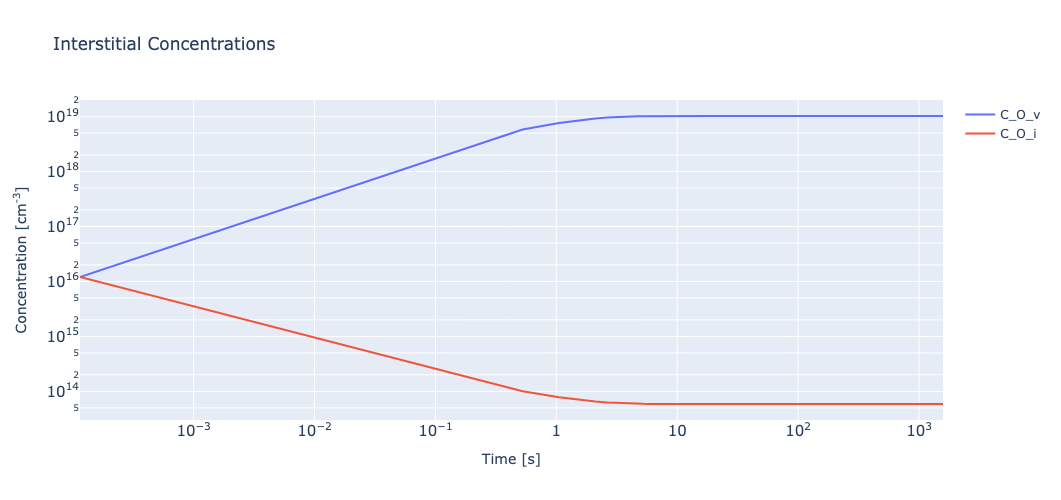

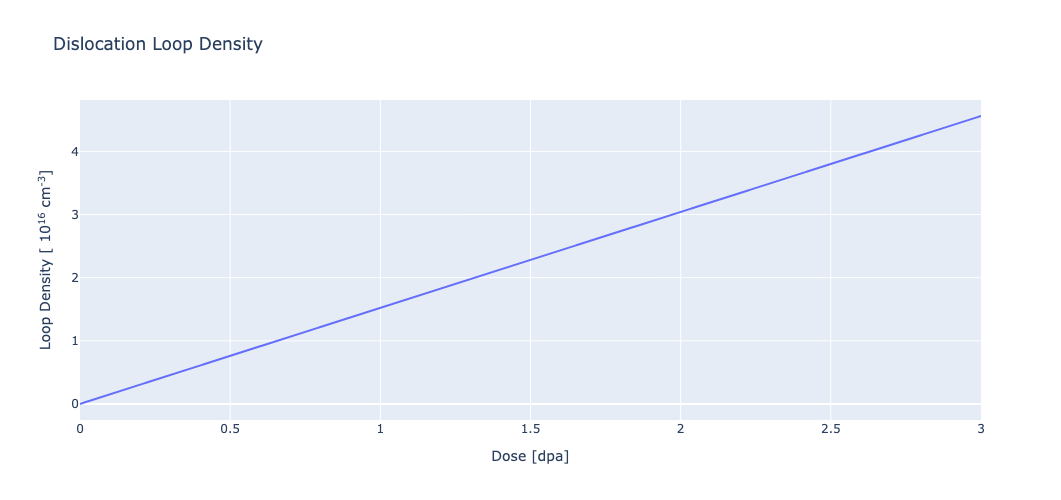

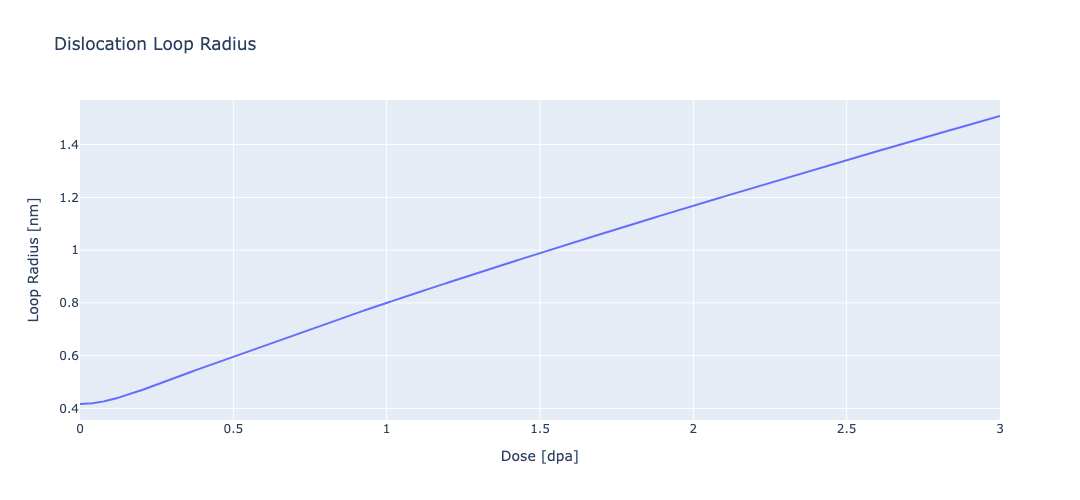

In [10]:
#Collect results and plot
solution = solve_ivp(ODE_system, method='BDF', t_span=t_span, y0=y0,
                     args=(ode_params,), t_eval=t_eval)

results = pd.DataFrame(solution.y.T,
                       columns=['C_Th_v','C_O_v','C_Th_i','C_O_i','N_L','R_L'])
results['time'] = solution.t

interactive_plots(results, G_0)

<h3>Doing the regression</h3>

In [11]:
#experimental data
lines = ['Red', 'Green', 'Blue']
filenames = [f'{lines[0]}-line-loop-diameter.csv', f'{lines[0]}-line-density.csv']

data1 = load_data(filenames[0], ['Dose (dpa)', 'Diameter (nm)'])
data2 = load_data(filenames[0], ['Dose (dpa)', 'Density (cm^-3)'])

dose_exp_R, dose_exp_N, R_exp, N_exp = data1['Dose (dpa)'], data2['Dose (dpa)'], data1['Diameter (nm)']*1e-7, data2['Density (cm^-3)']*1e16

In [12]:
# Combine experimental data into one array
data_all = np.concatenate([R_exp, N_exp])

# Initial guess and bounds
p0 = [0.836, 1.8, 0.6, 5.0]  #E_Th_i, E_O_v, E_O_i, k_lf,
bounds = ([0.5, 0.5, 0.5, 0], [4.0, 4.0, 4.0, 8])

# Perform fit
popt, pcov = curve_fit(
    lambda _, E_Th_i, E_O_v, E_O_i, k_lf: 
        fit_function(E_Th_i, E_O_v, E_O_i, k_lf,
                     dose_exp_R, dose_exp_N, y0, t_span, ode_params.copy(), G_0, t_eval),
    xdata=np.zeros_like(data_all), 
    ydata=data_all, 
    p0=p0, bounds=bounds
)

print("Best fit parameters:")
print(f"E_Th_i = {popt[0]:.3f} eV")
print(f"E_O_v  = {popt[1]:.3f} eV")
print(f"E_O_i  = {popt[2]:.3f} eV")
print(f"k_lf   = {popt[3]:.3e}")

Best fit parameters:
E_Th_i = 1.903 eV
E_O_v  = 2.216 eV
E_O_i  = 1.041 eV
k_lf   = 1.885e+00


<h2>Plotting fit</h2>

In [13]:
fit_params = ode_params.copy()

fit_params['D_Th_i'] = D_Coeff(D_0_Th_i, popt[0], T)
fit_params['D_O_i']  = D_Coeff(D_0_O_i, popt[1], T)
fit_params['D_O_v']  = D_Coeff(D_0_O_v, popt[2], T)
fit_params['k_lf']   = popt[3]

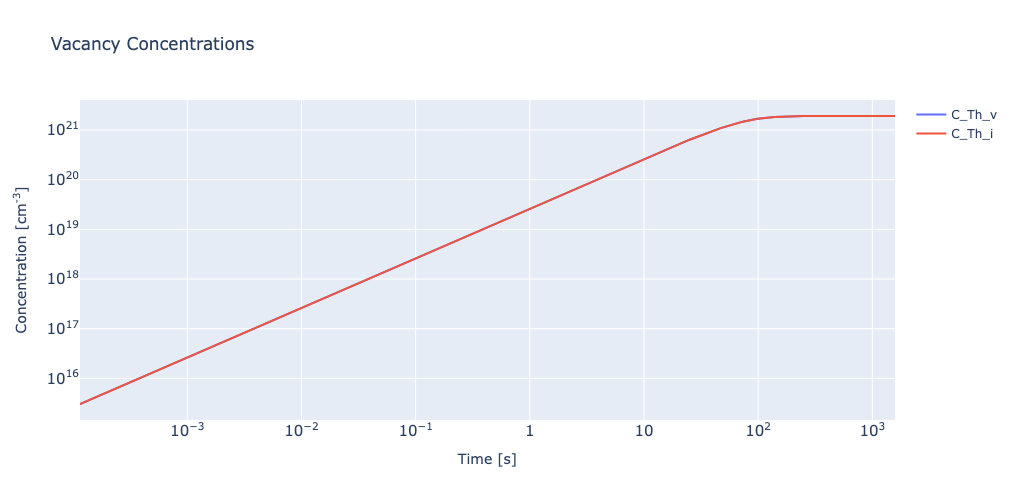

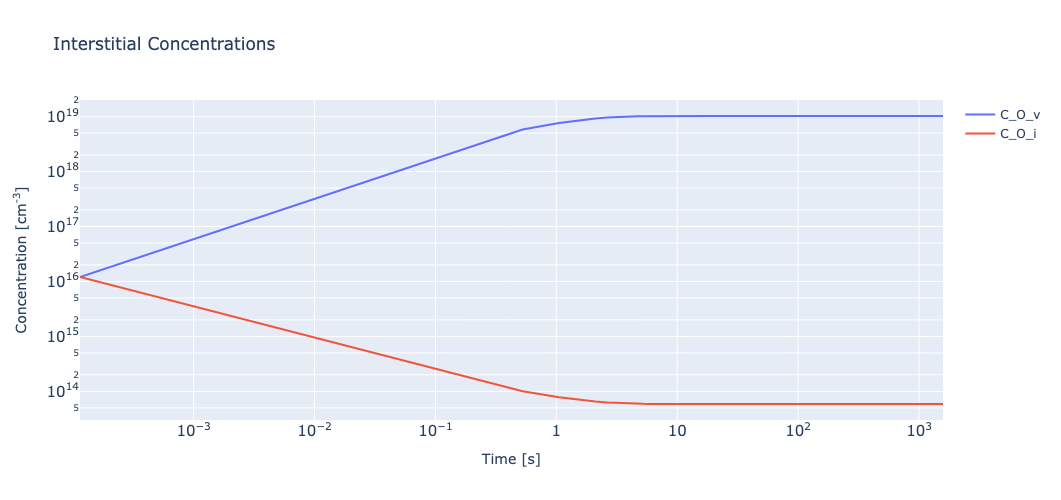

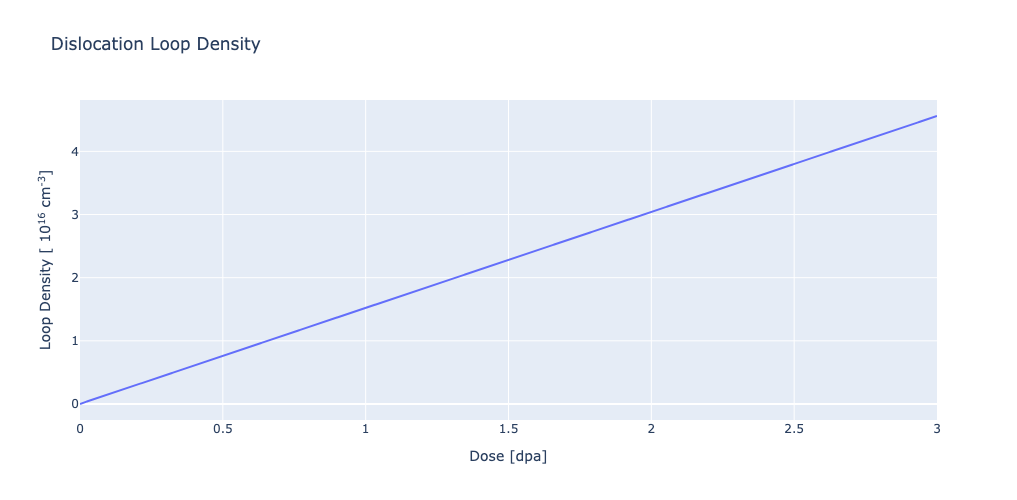

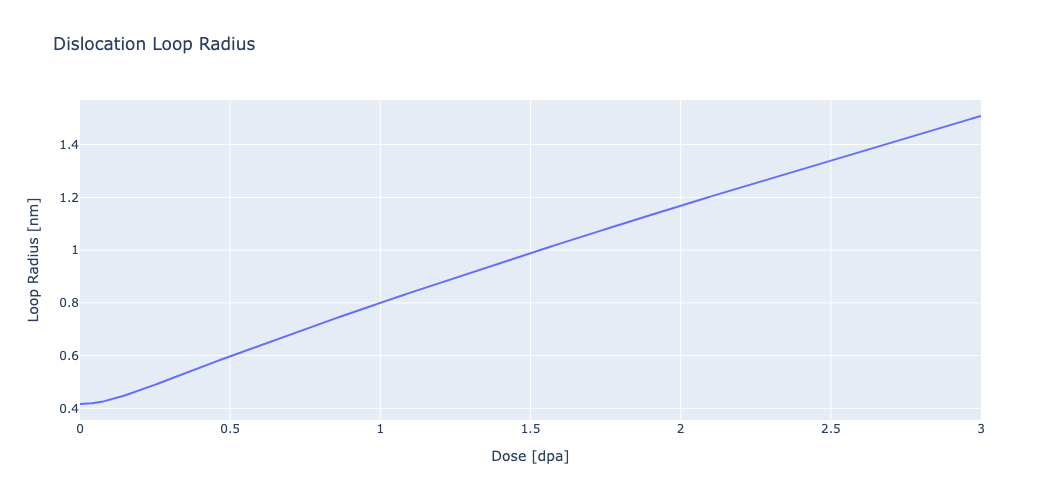

In [14]:
solution = solve_ivp(ODE_system, method='BDF', t_span=t_span, y0=y0,
                     args=(ode_params,), t_eval=t_eval)

results = pd.DataFrame(solution.y.T,
                       columns=['C_Th_v','C_O_v','C_Th_i','C_O_i','N_L','R_L'])
results['time'] = solution.t


interactive_plots(results, G_0)